# Machine learning tutorial at CMSDAS at CERN, June 2024
## Exercise 3: multiclass classification

Evan Armstrong Koenig, Matthias Komm, Pietro Vischia

The core of this tutorial comes from https://github.com/vischia/data_science_school_igfae2024 (Pietro Vischia (pietro.vischia@cern.ch)).

The CMSDAS version extends it to consider a convolutional network to regress Higgs quantities, plus some fixes.


In [1]:
# Uncomment and run this if you are running on Colab (remove only the "#", keep the "!").
# You can run it anyway, but it will do nothing if you have already installed all dependencies
# (and it will take some time to tell you it is not gonna do anything)


#from google.colab import drive
#drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/"
#! git clone https://github.com/vischia/data_science_school_igfae2024.git
#%cd machine_learning_tutorial
#!pwd
#!ls
#!pip install livelossplot shap

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['axes.labelsize'] = 14

import glob
import os
import re
import math
import socket
import json
import pickle
import gzip
import copy
import array
import numpy as np
import numpy.lib.recfunctions as recfunc
from tqdm import tqdm

#from scipy.optimize import newton
#from scipy.stats import norm

import uproot

import datetime
from timeit import default_timer as timer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing

import pandas as pd
import torchinfo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.functional as F

# Import data

We will use simulated events corresponding to three physics processes.

- ttH production
- ttW production
- Drell-Yan production

We will select the multilepton final state, which is a challenging final state with a rich structure and nontrivial background separation.

<img src="figs/2lss.png" alt="ttH multilepton 2lss" style="width:40%;"/>


In [3]:
INPUT_FOLDER = '/cmsuf/data/store/user/ekoenig/cmsdas/2024/short-ex-mlg'
sig = uproot.open(os.path.join(INPUT_FOLDER,'signal.root'))['Friends'].arrays(library="pd")
bk1 = uproot.open(os.path.join(INPUT_FOLDER,'background_1.root'))['Friends'].arrays(library="pd")
bk2 = uproot.open(os.path.join(INPUT_FOLDER,'background_2.root'))['Friends'].arrays(library="pd")

signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg1 = bk1.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg2 = bk2.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )

In [4]:
# This remains the same, but you will need to call it with one-vs-another or one-vs-all inputs
def plot_rocs(scores_labels_names):
    plt.figure()
    for score, label, name  in scores_labels_names:
        fpr, tpr, thresholds = roc_curve(label, score)
        plt.plot(
            fpr, tpr, 
            linewidth=2, 
            label=f"{name} (AUC = {100.*auc(fpr, tpr): .2f} %)"
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

In [5]:
device = torch.device("cpu")

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
if torch.cuda.is_available() and torch.cuda.device_count()>0:
    device = torch.device("cuda")
    
print ("Available device: ",device)

Available device:  cpu


## Multiclass

Go back to the original dataset, but now assign different labels to the two backgrounds

In [6]:
signal['label'] = 2
bkg1['label'] = 1
bkg2['label'] = 0
bkg = pd.concat([bkg1, bkg2])

Now you need to apply the technique of **one-hot encoding** to convert a categorical label (=0,1,2) into a vector (one dimension per category/class):


| Sample | Categorical | One-hot encoding |
| --- | --- | --- |
| Background 2 | $0$ | $(1,0,0)$ |
| Background 1 | $1$ | $(0,1,0)$ |
| Signal | $2$ | $(0,0,1)$ |


You can use the function `one_hot = torch.nn.functional.one_hot(target)` to one-hot encode the target labels (both for signal and background)

In [7]:
#check encoding
for label in [0,1,2]:
    one_hot = torch.nn.functional.one_hot(torch.tensor(label), num_classes=3)
    print (f"Encoding label '{label}' as '{one_hot.numpy(force=True)}'")

Encoding label '0' as '[1 0 0]'
Encoding label '1' as '[0 1 0]'
Encoding label '2' as '[0 0 1]'


In [8]:
data = pd.concat([signal,bkg]).sample(frac=1).reset_index(drop=True)
X = data.drop(["label"], axis=1)
y = data["label"]
    
print(f"Original label shape {y.shape}")
y = torch.nn.functional.one_hot(torch.tensor(y), num_classes=3)
y = y.to(dtype=torch.float32)
print(f"Encoded label shape {y.shape}")

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
print("We have", len(X_train), "training samples and ", len(X_test), "testing samples")


Ntrain=10000
Ntest=2000
X_train = X_train[:Ntrain]
y_train = y_train[:Ntrain]
X_test = X_test[:Ntest]
y_test = y_test[:Ntest]

# Try with and without!
#from sklearn.preprocessing import StandardScaler

#fit transformation to train dataset
#scaler = StandardScaler().fit(X_train)

#apply transformation for train and test
#X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
#X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])


Original label shape (1890839,)
Encoded label shape torch.Size([1890839, 3])
We have 1266862 training samples and  623977 testing samples


Next you have to modify the neural network model: the output must be a dimension-three vector rather than a scalar.

You can use `self.output = nn.Linear(8, 3)` as last layer, and here we use the `softmax` activation function, to ensure the outputs are interpretable as  probabilities per label, ie. the output will be a 3-dim vector with $(P_\textrm{bkg1},P_\textrm{bkg2},P_\textrm{sig})$ and the probabilities are normalized as $P_\textrm{bkg1}+P_\textrm{bkg2}+P_\textrm{sig}=1$.



In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, ninputs, device=torch.device("cpu")):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ninputs, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,8),
            nn.ReLU(),
            nn.Linear(8, 3),
            nn.Softmax(dim=1)
        )
        self.linear_relu_stack.to(device)

    def forward(self, x):
        # Pass data through conv1
        x = self.linear_relu_stack(x)
        return x

class MyDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values if isinstance(X, pd.core.frame.DataFrame) else X).to(device)
        self.y = y.to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]
        
        return datum, label

train_dataset = MyDataset(X_train, y_train, device=device)
test_dataset = MyDataset(X_test, y_test, device=device)
batch_size = 2048

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

random_batch_X, random_batch_y = next(iter(train_dataloader))

print("The new dataloader puts the batches in in", random_batch_X.get_device())

# Reinstantiate the model, on the chosen device
model = NeuralNetwork(X_train.shape[1], device)


def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #for batch, (X, y) in enumerate(dataloader):
    #for batch, (X, y) in tqdm(enumerate(dataloader, 0), unit="batch", total=len(dataloader)):
    for (X,y) in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        #if (all_equal3(pred.detach().numpy())):
        #    print("All equal!")
        loss = loss_fn(pred, y)
        losses.append(loss.detach().cpu())
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses)
    
def test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        #for X, y in dataloader:
        #for batch, (X, y) in tqdm(enumerate(dataloader, 0), unit="batch", total=len(dataloader)):
        for (X,y) in tqdm(dataloader):
            pred = model(X)
            loss = loss_fn(pred, y).item()
            losses.append(loss)
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses)

epochs=100
learningRate = 0.01
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_losses=[]
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss=test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")

The new dataloader puts the batches in in -1
Epoch 1
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.34it/s]


Avg train loss 1.0001339 , Avg test loss 0.8769325017929077 Current learning rate [0.009000000000000001]
Epoch 2
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.58it/s]


Avg train loss 0.8691716 , Avg test loss 0.858101487159729 Current learning rate [0.008100000000000001]
Epoch 3
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 108.14it/s]


Avg train loss 0.86078376 , Avg test loss 0.8551422953605652 Current learning rate [0.007290000000000001]
Epoch 4
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 115.00it/s]


Avg train loss 0.859087 , Avg test loss 0.8539892435073853 Current learning rate [0.006561000000000002]
Epoch 5
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 88.07it/s]


Avg train loss 0.85766727 , Avg test loss 0.8532963395118713 Current learning rate [0.005904900000000002]
Epoch 6
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.24it/s]


Avg train loss 0.8573907 , Avg test loss 0.8528895974159241 Current learning rate [0.005314410000000002]
Epoch 7
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 108.82it/s]


Avg train loss 0.8566812 , Avg test loss 0.8526017069816589 Current learning rate [0.004782969000000002]
Epoch 8
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.44it/s]


Avg train loss 0.8567468 , Avg test loss 0.8523836135864258 Current learning rate [0.004304672100000002]
Epoch 9
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.13it/s]


Avg train loss 0.85630894 , Avg test loss 0.8522140979766846 Current learning rate [0.003874204890000002]
Epoch 10
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 101.32it/s]


Avg train loss 0.8564606 , Avg test loss 0.8520728945732117 Current learning rate [0.003486784401000002]
Epoch 11
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 108.46it/s]


Avg train loss 0.8562447 , Avg test loss 0.8519576787948608 Current learning rate [0.003138105960900002]
Epoch 12
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 116.22it/s]


Avg train loss 0.85574263 , Avg test loss 0.8518604636192322 Current learning rate [0.0028242953648100018]
Epoch 13
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.04it/s]


Avg train loss 0.8557504 , Avg test loss 0.8517767786979675 Current learning rate [0.0025418658283290017]
Epoch 14
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.57it/s]


Avg train loss 0.85608685 , Avg test loss 0.8517050743103027 Current learning rate [0.0022876792454961017]
Epoch 15
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.34it/s]


Avg train loss 0.85567397 , Avg test loss 0.8516398668289185 Current learning rate [0.0020589113209464917]
Epoch 16
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.59it/s]


Avg train loss 0.85549295 , Avg test loss 0.8515800833702087 Current learning rate [0.0018530201888518425]
Epoch 17
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.26it/s]


Avg train loss 0.85527086 , Avg test loss 0.8515269756317139 Current learning rate [0.0016677181699666583]
Epoch 18
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.53it/s]


Avg train loss 0.85569304 , Avg test loss 0.8514808416366577 Current learning rate [0.0015009463529699924]
Epoch 19
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 105.29it/s]


Avg train loss 0.85535336 , Avg test loss 0.8514342308044434 Current learning rate [0.0013508517176729932]
Epoch 20
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.79it/s]


Avg train loss 0.8553095 , Avg test loss 0.8513878583908081 Current learning rate [0.001215766545905694]
Epoch 21
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.62it/s]


Avg train loss 0.8552661 , Avg test loss 0.851345419883728 Current learning rate [0.0010941898913151245]
Epoch 22
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.84it/s]


Avg train loss 0.8556722 , Avg test loss 0.8513082265853882 Current learning rate [0.0009847709021836122]
Epoch 23
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.80it/s]


Avg train loss 0.85524863 , Avg test loss 0.8512747287750244 Current learning rate [0.0008862938119652509]
Epoch 24
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.75it/s]


Avg train loss 0.85527086 , Avg test loss 0.8512438535690308 Current learning rate [0.0007976644307687258]
Epoch 25
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 109.98it/s]


Avg train loss 0.8551868 , Avg test loss 0.8512154817581177 Current learning rate [0.0007178979876918532]
Epoch 26
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 114.01it/s]


Avg train loss 0.8551507 , Avg test loss 0.851189136505127 Current learning rate [0.0006461081889226679]
Epoch 27
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.60it/s]


Avg train loss 0.8551527 , Avg test loss 0.8511649370193481 Current learning rate [0.0005814973700304011]
Epoch 28
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.92it/s]


Avg train loss 0.85509074 , Avg test loss 0.8511427640914917 Current learning rate [0.0005233476330273611]
Epoch 29
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 107.65it/s]


Avg train loss 0.855155 , Avg test loss 0.8511232733726501 Current learning rate [0.000471012869724625]
Epoch 30
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 109.39it/s]


Avg train loss 0.85491884 , Avg test loss 0.8511054515838623 Current learning rate [0.0004239115827521625]
Epoch 31
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.21it/s]


Avg train loss 0.85488063 , Avg test loss 0.851089358329773 Current learning rate [0.00038152042447694626]
Epoch 32
-------------------------------


100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


Avg train loss 0.8551842 , Avg test loss 0.8510743975639343 Current learning rate [0.00034336838202925164]
Epoch 33
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 109.18it/s]


Avg train loss 0.8550701 , Avg test loss 0.851061224937439 Current learning rate [0.0003090315438263265]
Epoch 34
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 115.99it/s]


Avg train loss 0.85529196 , Avg test loss 0.8510492444038391 Current learning rate [0.00027812838944369386]
Epoch 35
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.64it/s]


Avg train loss 0.85474503 , Avg test loss 0.85103839635849 Current learning rate [0.0002503155504993245]
Epoch 36
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.50it/s]


Avg train loss 0.8551828 , Avg test loss 0.8510284423828125 Current learning rate [0.00022528399544939206]
Epoch 37
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.15it/s]


Avg train loss 0.85501003 , Avg test loss 0.8510196805000305 Current learning rate [0.00020275559590445286]
Epoch 38
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.98it/s]


Avg train loss 0.85478336 , Avg test loss 0.8510115146636963 Current learning rate [0.00018248003631400757]
Epoch 39
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.06it/s]


Avg train loss 0.85470724 , Avg test loss 0.8510040640830994 Current learning rate [0.00016423203268260683]
Epoch 40
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.87it/s]


Avg train loss 0.85507727 , Avg test loss 0.8509975075721741 Current learning rate [0.00014780882941434616]
Epoch 41
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 107.06it/s]


Avg train loss 0.85466796 , Avg test loss 0.8509920835494995 Current learning rate [0.00013302794647291155]
Epoch 42
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.47it/s]


Avg train loss 0.8549668 , Avg test loss 0.8509870767593384 Current learning rate [0.00011972515182562039]
Epoch 43
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 101.84it/s]


Avg train loss 0.85515976 , Avg test loss 0.8509824872016907 Current learning rate [0.00010775263664305835]
Epoch 44
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 107.60it/s]


Avg train loss 0.8550833 , Avg test loss 0.850978434085846 Current learning rate [9.697737297875251e-05]
Epoch 45
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 109.84it/s]


Avg train loss 0.8547661 , Avg test loss 0.8509747982025146 Current learning rate [8.727963568087727e-05]
Epoch 46
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 109.40it/s]


Avg train loss 0.855007 , Avg test loss 0.8509714603424072 Current learning rate [7.855167211278955e-05]
Epoch 47
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 115.60it/s]


Avg train loss 0.85518587 , Avg test loss 0.8509685397148132 Current learning rate [7.06965049015106e-05]
Epoch 48
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.98it/s]


Avg train loss 0.8551294 , Avg test loss 0.8509657979011536 Current learning rate [6.362685441135955e-05]
Epoch 49
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.79it/s]


Avg train loss 0.8551167 , Avg test loss 0.8509634733200073 Current learning rate [5.7264168970223595e-05]
Epoch 50
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 103.97it/s]


Avg train loss 0.85480416 , Avg test loss 0.8509612679481506 Current learning rate [5.153775207320124e-05]
Epoch 51
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 116.17it/s]


Avg train loss 0.854669 , Avg test loss 0.8509593605995178 Current learning rate [4.6383976865881114e-05]
Epoch 52
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 106.64it/s]


Avg train loss 0.85489684 , Avg test loss 0.8509575724601746 Current learning rate [4.1745579179293e-05]
Epoch 53
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 104.78it/s]


Avg train loss 0.85495174 , Avg test loss 0.8509559035301208 Current learning rate [3.75710212613637e-05]
Epoch 54
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.37it/s]


Avg train loss 0.85500735 , Avg test loss 0.8509545922279358 Current learning rate [3.381391913522733e-05]
Epoch 55
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.30it/s]


Avg train loss 0.855111 , Avg test loss 0.850953221321106 Current learning rate [3.0432527221704597e-05]
Epoch 56
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 103.10it/s]


Avg train loss 0.8545214 , Avg test loss 0.8509522080421448 Current learning rate [2.7389274499534138e-05]
Epoch 57
-------------------------------


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


Avg train loss 0.85493547 , Avg test loss 0.8509511351585388 Current learning rate [2.4650347049580723e-05]
Epoch 58
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.15it/s]


Avg train loss 0.8547533 , Avg test loss 0.8509501814842224 Current learning rate [2.218531234462265e-05]
Epoch 59
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 109.52it/s]


Avg train loss 0.8549937 , Avg test loss 0.8509493470191956 Current learning rate [1.9966781110160387e-05]
Epoch 60
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.97it/s]


Avg train loss 0.85500354 , Avg test loss 0.8509485721588135 Current learning rate [1.797010299914435e-05]
Epoch 61
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 116.14it/s]


Avg train loss 0.85476446 , Avg test loss 0.8509478569030762 Current learning rate [1.6173092699229914e-05]
Epoch 62
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 40.93it/s]


Avg train loss 0.8548439 , Avg test loss 0.8509473204612732 Current learning rate [1.4555783429306922e-05]
Epoch 63
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 107.81it/s]


Avg train loss 0.85527354 , Avg test loss 0.8509467840194702 Current learning rate [1.310020508637623e-05]
Epoch 64
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.39it/s]


Avg train loss 0.8548115 , Avg test loss 0.8509462475776672 Current learning rate [1.1790184577738607e-05]
Epoch 65
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.71it/s]


Avg train loss 0.8551965 , Avg test loss 0.8509458303451538 Current learning rate [1.0611166119964747e-05]
Epoch 66
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 108.12it/s]


Avg train loss 0.8552171 , Avg test loss 0.8509454131126404 Current learning rate [9.550049507968273e-06]
Epoch 67
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.84it/s]


Avg train loss 0.85500115 , Avg test loss 0.850944995880127 Current learning rate [8.595044557171446e-06]
Epoch 68
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 108.86it/s]


Avg train loss 0.8547702 , Avg test loss 0.8509447574615479 Current learning rate [7.735540101454301e-06]
Epoch 69
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.11it/s]


Avg train loss 0.85518247 , Avg test loss 0.8509443998336792 Current learning rate [6.9619860913088715e-06]
Epoch 70
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 116.16it/s]


Avg train loss 0.85472804 , Avg test loss 0.8509441614151001 Current learning rate [6.265787482177985e-06]
Epoch 71
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 114.15it/s]


Avg train loss 0.8551515 , Avg test loss 0.850943922996521 Current learning rate [5.639208733960187e-06]
Epoch 72
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 114.92it/s]


Avg train loss 0.854684 , Avg test loss 0.8509437441825867 Current learning rate [5.075287860564168e-06]
Epoch 73
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 105.75it/s]


Avg train loss 0.855189 , Avg test loss 0.8509436249732971 Current learning rate [4.5677590745077515e-06]
Epoch 74
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 114.28it/s]


Avg train loss 0.8549293 , Avg test loss 0.850943386554718 Current learning rate [4.110983167056976e-06]
Epoch 75
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.58it/s]


Avg train loss 0.85502815 , Avg test loss 0.8509432077407837 Current learning rate [3.6998848503512788e-06]
Epoch 76
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.42it/s]


Avg train loss 0.85474145 , Avg test loss 0.8509430885314941 Current learning rate [3.329896365316151e-06]
Epoch 77
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.93it/s]


Avg train loss 0.85511124 , Avg test loss 0.8509429693222046 Current learning rate [2.9969067287845362e-06]
Epoch 78
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 109.84it/s]


Avg train loss 0.8549199 , Avg test loss 0.8509429097175598 Current learning rate [2.6972160559060827e-06]
Epoch 79
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.53it/s]


Avg train loss 0.8547996 , Avg test loss 0.8509427309036255 Current learning rate [2.4274944503154745e-06]
Epoch 80
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 107.68it/s]


Avg train loss 0.8547446 , Avg test loss 0.8509426712989807 Current learning rate [2.1847450052839273e-06]
Epoch 81
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.19it/s]


Avg train loss 0.8549406 , Avg test loss 0.8509426116943359 Current learning rate [1.9662705047555346e-06]
Epoch 82
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 106.07it/s]


Avg train loss 0.8554322 , Avg test loss 0.8509426116943359 Current learning rate [1.7696434542799813e-06]
Epoch 83
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.18it/s]


Avg train loss 0.8548299 , Avg test loss 0.8509424924850464 Current learning rate [1.5926791088519833e-06]
Epoch 84
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 114.33it/s]


Avg train loss 0.8549495 , Avg test loss 0.8509424924850464 Current learning rate [1.433411197966785e-06]
Epoch 85
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 112.70it/s]


Avg train loss 0.85504496 , Avg test loss 0.8509424924850464 Current learning rate [1.2900700781701065e-06]
Epoch 86
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.56it/s]


Avg train loss 0.85472596 , Avg test loss 0.8509423136711121 Current learning rate [1.161063070353096e-06]
Epoch 87
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 110.53it/s]


Avg train loss 0.85511935 , Avg test loss 0.8509423732757568 Current learning rate [1.0449567633177863e-06]
Epoch 88
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 109.04it/s]


Avg train loss 0.855099 , Avg test loss 0.8509423136711121 Current learning rate [9.404610869860078e-07]
Epoch 89
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 105.61it/s]


Avg train loss 0.8549426 , Avg test loss 0.8509423732757568 Current learning rate [8.46414978287407e-07]
Epoch 90
-------------------------------


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Avg train loss 0.855054 , Avg test loss 0.8509423136711121 Current learning rate [7.617734804586663e-07]
Epoch 91
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.30it/s]


Avg train loss 0.85486966 , Avg test loss 0.8509422540664673 Current learning rate [6.855961324127997e-07]
Epoch 92
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 106.16it/s]


Avg train loss 0.8552197 , Avg test loss 0.8509422540664673 Current learning rate [6.170365191715197e-07]
Epoch 93
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 113.03it/s]


Avg train loss 0.85494775 , Avg test loss 0.8509423136711121 Current learning rate [5.553328672543678e-07]
Epoch 94
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 104.61it/s]


Avg train loss 0.8548926 , Avg test loss 0.8509421944618225 Current learning rate [4.99799580528931e-07]
Epoch 95
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.87it/s]


Avg train loss 0.8550414 , Avg test loss 0.8509422540664673 Current learning rate [4.498196224760379e-07]
Epoch 96
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 115.25it/s]


Avg train loss 0.8547902 , Avg test loss 0.8509422540664673 Current learning rate [4.0483766022843414e-07]
Epoch 97
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 109.93it/s]


Avg train loss 0.8549968 , Avg test loss 0.8509421944618225 Current learning rate [3.643538942055907e-07]
Epoch 98
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 111.05it/s]


Avg train loss 0.8550213 , Avg test loss 0.8509422540664673 Current learning rate [3.2791850478503163e-07]
Epoch 99
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 108.26it/s]


Avg train loss 0.8552561 , Avg test loss 0.8509422540664673 Current learning rate [2.951266543065285e-07]
Epoch 100
-------------------------------


100%|██████████| 1/1 [00:00<00:00, 108.63it/s]

Avg train loss 0.85492975 , Avg test loss 0.8509421348571777 Current learning rate [2.6561398887587566e-07]
Done!


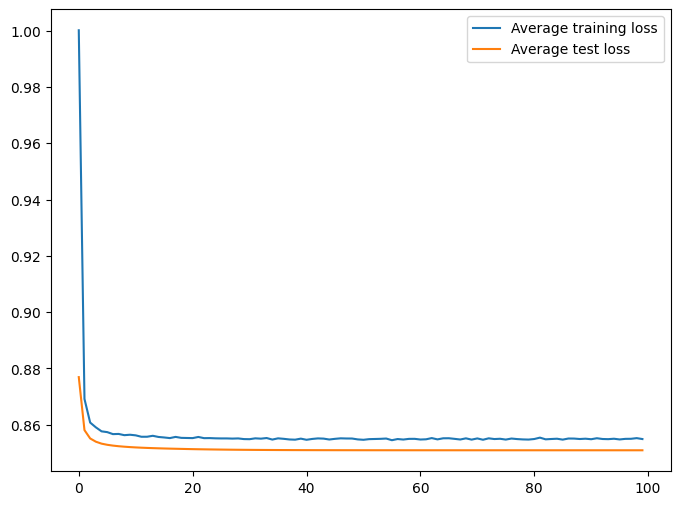

In [10]:
plt.figure()
plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.legend(loc="best")
plt.show()
plt.close()

After training, you will need to figure out how to get categorical predictions to be able to test performance (for instance to do confusion matrices for each pair of classes, or for one class against all the others.

true class | predicted class 
2          | 1              
0          | 0              
0          | 0              
1          | 1              
0          | 0              
0          | 1              
0          | 0              
1          | 1              
0          | 0              
1          | 1              


<Figure size 800x600 with 0 Axes>

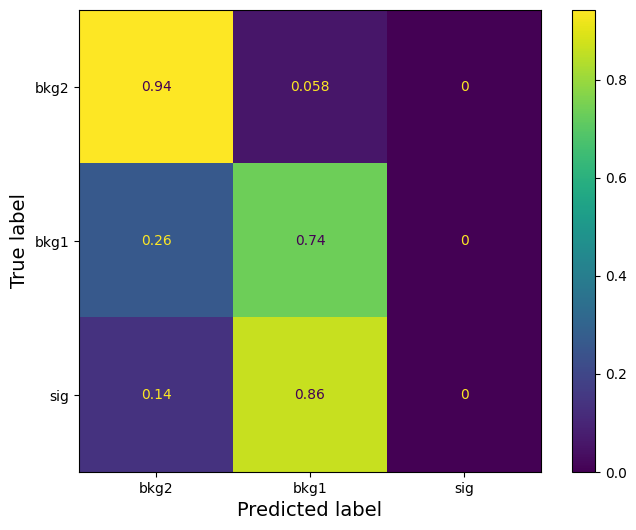

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_y = model(torch.tensor(X_test.values, device=device)).numpy(force=True)
pred_class = np.argmax(pred_y,axis=1)
true_class = np.argmax(y_test.numpy(force=True),axis=1)

print (f"{'true class':10s} | {'predicted class':15s} ")
print ('='*30)
for i in range(10):
    print (f"{true_class[i]:<10d} | {pred_class[i]:<15d}")

confusion_mat = confusion_matrix(true_class, pred_class, normalize='true')
                                 
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['bkg2', 'bkg1', 'sig'])
disp.plot()
plt.show()
plt.close()

## Exercise

Calculate the predictions for each class, then plot the ROC curve for:

- signal vs bkg1
- signal vs bkg2
- bkg vs bkg2

Then, in another plot, plot:

- signal vs all backgrounds


### The end